# Transformer

L'objectif est de construire un modèle avec pytorch basé sur l'architecture transformer présenté dans le papier : [Attention is All You need](https://arxiv.org/abs/1706.03762)

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

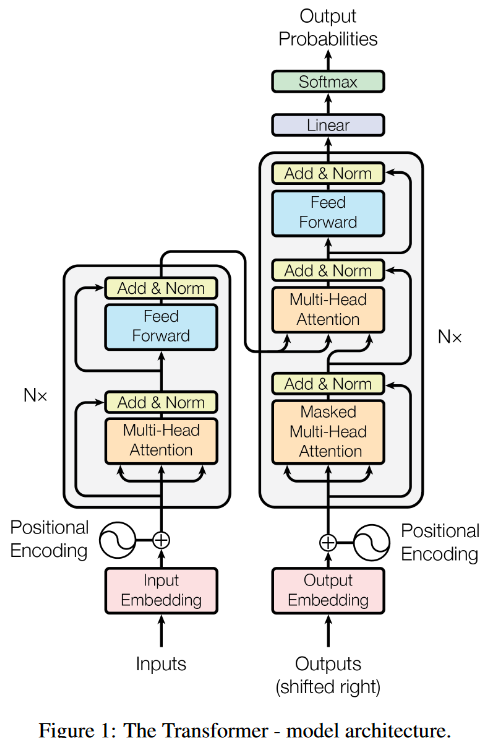

## 1. L'architecture du Transformer

### Le bloc Input Embedding

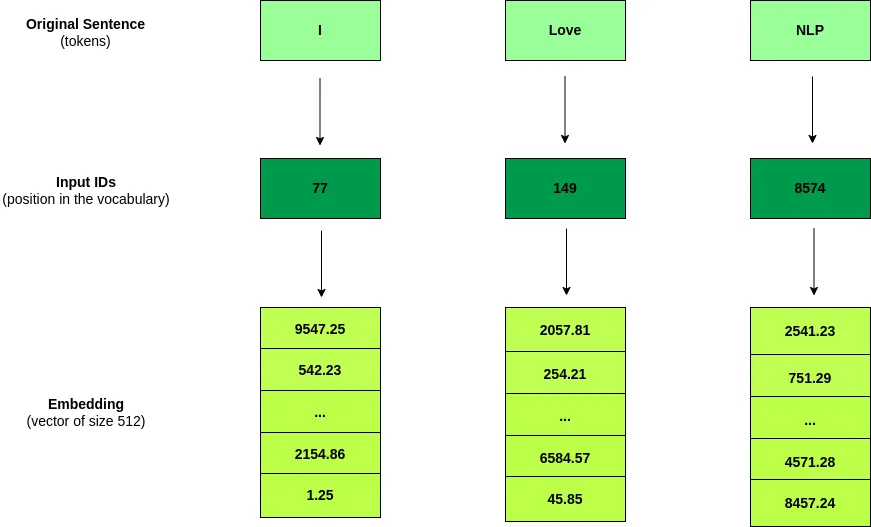

In [35]:
class InputEmbeddings(nn.Module):
    def __init__(self, embed_dim: int, vocab_size: int) -> None:
        """Initialisation de l'InputEmbeddings.

        Permet de convertir la phrase originale en un vecteur de embed_dim dimenssions.
        La couche Embedding est intialisée avec des poids aléatoires et les vecteurs
          correspondants aux indices sont appris durant l'entrainement. De cette façon,
          pour un nb donné, ça donnera toujours le même vecteur.

        Args:
            embed_dim : dimenssion de l'entrée du modèle. Dans le papier, 512 pour
              le modèle de base et 1024 pour la version large.
            vocab_size : taille du vocabulaire de l'entrée
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        # Création d'une couche d'embedding qui map les indices en un vecteur de dimenssion embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x):
        """Le embedding layer cherche le vecteur correspondant à chaque token de x,
          le tensor avec les indices des tokens.

        Les embeddings sont multipliés par la racine carré de embed_dim pour les mettres
          à l'échelle. C'est pour maintenir la variances des embeddings au travers
          du réseau, ce qui aide à maitenir la stabilité de l'entrainement.

        Args:
            x (batch, seq_len) : tensor avec les indices des tokens
        Returns :
            (batch, seq_len, embed_dim) : tensor avec les vecteurs d'embedding des tokens
        """
        # Multiply by sqrt(embed_dim) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.embed_dim)

### Le bloc Positional Encoding

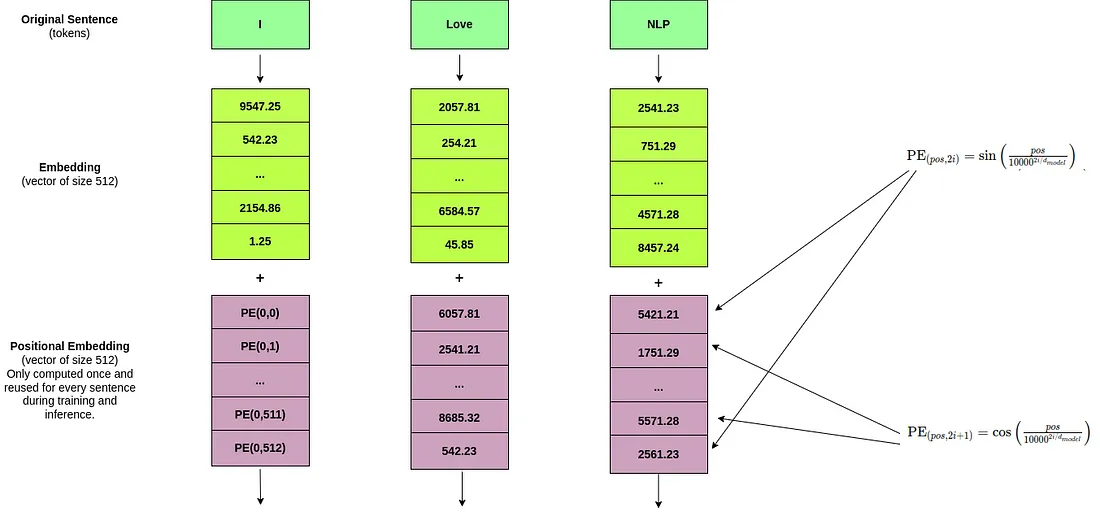
* *.unsqueeze(1)* : ajoute une dimenssion supplémentaire au tensor à l'index 1 donc la 2ème dimenssion.
* *register_buffer()* : method in the nn.Module class that is used to register a persistent buffer in a module. These buffers are tensors that are not considered model parameters, meaning they are not updated during the optimization process. However, they are still saved and loaded along with the model's state_dict.
* *requires_grad_(False)* : tell model to not to learn these pos encoding because they are fixed and will always be same

In [36]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int, max_seq_length: int, dropout: float):
        """Initialisation du bloc Positional Encoding.

        Ca permet d'injecter l'information de la position de chaque token dans la
          séquence d'entrée. Sinon comme le transformer traite toute la séquence en
          simultanné, il n'y aurait pas d'infos sur l'ordre des tokens.
        Les fcts sinuoidales utilisées sont choisis pour permettre au modèle d'apprendre facilement
          à tenir compte de la position relative comme ils produisent en encodage unique et
          léger pour chaque position dans la séquence.

        Args:
            embed_dim : dimenssion de l'entrée du modèle (embeddings)
            max_seq_length : longueur maximale de la séquence pour laquelle le
              positional encoding est pré-calculé
            dropout : taux de dropout utilisé pour la régularisation
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Initilisation d'un tensor de 0
        pe = torch.zeros(max_seq_length, embed_dim)  # (seq_len, embed_dim)

        # Tensor avec les indices de position de la séquence
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)  #  (seq_len, 1)
        # Terme utilisé pour mettre à l'échelle les indices (log space for numerical stability)
        div_term = torch.exp(torch.arange(0, embed_dim, step=2).float() * -(math.log(10000.0) / embed_dim))  # (embed_dim/2)

        # On applique la fct sin sur les indices paires et la fct cos sur les impaires
        pe[:, 0::2] = torch.sin(position * div_term)  # sin(position * (10000 ** (2i / embed_dim))
        pe[:, 1::2] = torch.cos(position * div_term)  # cos(position * (10000 ** (2i / embed_dim))

        # Ajout d'une dimenssion pour le batch dans le positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, embed_dim)

        # On enregistre pe comme un buffer
        # (paramètre non entrainable mais qui doit doit être sauvé dans le state_dict)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """Ajoute les positional à l'entrée aux embeddings de l'entrée x."""
        seq_len = x.size(1)
        x = x + (self.pe[:, :seq_len, :]).requires_grad_(False)  # (batch, seq_len, embed_dim)
        return self.dropout(x)

### Le bloc LayerNormalization


In [37]:
class LayerNormalization(nn.Module):
    def __init__(self, features: int=512, eps:float=10**-6) -> None:
        """Initialisation du bloc LayerNormalization.

        Permet d'améliorer l'entrainement du réseau de neurones en normalisant chaque
          entrée (embedding de chaque token) par rapport à ses features.
        Ca aide à stabiliser l'entrainement, améliore la convergence et réduit
          la dépendance à l'initialisation des paramètres.

        Args:
            features : dimenssion des vecteurs d'embeddings
            eps : float très petit pour éviter de diviser par 0
        """
        super().__init__()
        self.eps = eps
        # On définit deux paramètres apprenables (avec nn.Parameter)
        self.alpha = nn.Parameter(torch.ones(features)) # scale parameter
        self.bias = nn.Parameter(torch.zeros(features)) # shift parameter

    def forward(self, x):
        """Fonction pour normaliser chaque embedding en soustrayant sa moyenne
          et en divisant par sa standard deviation.

        Le process est fait pour chaque token indépendamment , pour s'assurer que
          l'embedding de chaque token est normalisé selon ses propres features.

        alpha : After normalization, the data is centered around zero with unit variance.
          alpha allows the model to scale the normalized data.
        bias : After scaling the data with gamma, the bias parameter allows the
          model to shift the normalized data.
        eps : to prevent dividing by zero or when std is very small

        Args:
          x (batch, seq_len, embed_dim) : entrée du bloc
        """
        # On calcule la mean et std sur chaque embedding (vecteur de taille embed_dim)
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

### Le bloc Feed-Forward

In [38]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim: int, d_ff: int, dropout: float):
        """Initialisation du bloc FeedForward.

        Ce sont deux 2 transformations linéaires avec une activation ReLU entre.
        Ca aide à ajouter de la non linéarité au modèle, ce qui lui permet d'apprendre
          des patternes plus complexes.
        Il aide à transformer les features apprises par les mécanismes d'attention
         en agissant comme une étape additionelle de traitement pour les sorties
         de l'attention.

        Args:
            embed_dim : dimenssion de l'entrée et sortie du modèle
            d_ff : dimenssion de la couche cachée du feed-forward network
        """
        super().__init__()
        # 2 couches entierement connecté
        self.linear1 = nn.Linear(embed_dim, d_ff)
        self.linear2 = nn.Linear(d_ff, embed_dim)
        # Fct activation ReLU pour introduire une non-linéarité entre les 2 couches linéaires
        self.relu = nn.ReLU()
        # Dropout pour régulariser et éviter l'overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """Application du feed-forward network sur x.

        La sortie de fc1 est passée dans une fct d'activation ReLU. Cette dernière
          va remplacer toutes les valeurs négatives par zéro pour introduire une
          non linéarité dans le modèle.

        Args:
            x (batch, seq_len, embed_dim) : entrée du bloc
        """
        return self.linear2(self.dropout(self.relu(self.linear1(x))))

### Le bloc Multi-Head Attention

In [39]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float):
      """Initialisation du module de MultiHeadAttention.

      L'entré va être traité par plusieurs têtes d'attention qui vont chacunes appliquer
       l'attention sur l'entrée et ensuite combiner le résultat.
      Ainsi, le modèle peut capturer des relations variées dans les données d'entrée
        à différentes échelles, ce qui va améliorer les capacités du modèle.

      Args:
          embed_dim : dimenssion des données en entrée
          num_heads : nb de têtes d'attention où il faut séparer l'entrée
          dropout : taux de dropout utilisé pour la régularisation
      """
      super().__init__()
      # Ensure that the model dimension (embed_dim) is divisible by the number of heads
      assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

      self.embed_dim = embed_dim # Model's dimension (eg 512)
      self.num_heads = num_heads # Number of attention heads (eg 8)
      self.d_k = embed_dim // num_heads # Dimension of each head's key, query, and value

      # Linear layers for transforming inputs
      self.W_q = nn.Linear(embed_dim, embed_dim, bias=False) # Query transformation
      self.W_k = nn.Linear(embed_dim, embed_dim, bias=False) # Key transformation
      self.W_v = nn.Linear(embed_dim, embed_dim, bias=False) # Value transformation
      self.W_o = nn.Linear(embed_dim, embed_dim, bias=False) # Output transformation
      self.dropout = nn.Dropout(dropout)

    @staticmethod  # pour utiliser la fct sans avoir besoin de créer un objet
    def scaled_dot_product_attention(Q, K, V, mask=None, dropout=None):
        """Calcul de l'attention.

        1. Calcul des scores d'attention en prenant le produit scalaire de Q et K
          et en le mettant à l'échelle par la racine carré de la dimenssion des key (d_k)
           La division par `√dk` permet d'éviter d'avoir les produits scalaires qui grossissent trop.
        2. Si un masque est fournit, on l'applique sur le score d'attention pour masquer
          des valeurs spécifiques.
        3. Calcul des poids d'attention : les scores d'atttention sont passés dans un
          softmax pour les transfromer en probabilités dont la somme fait 1.
        4. Calcul de la sortie finale de l'attention en multipliant les poids d'attention
          par la matrice des values V.

        Args:
            Q (batch, h, seq_len, d_k): Matrice des queries
            K (batch, h, seq_len, d_k): Matrice des keys
            V (batch, h, seq_len, d_k): Matrice des values
            mask : Matrice de masque (optionnelle)
        """
        # Calculate attention scores
        d_k = Q.shape[-1]
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # (batch, h, seq_len, seq_len)

        # Application d'un masque si fourni (utile pour éviter l'attention sur des parties comme le padding)
        if mask is not None:
            # Valeur très faible pour simuler -inf
            attention_scores = attention_scores.masked_fill(mask == 0, -1e20)

        # Softmax is applied to obtain attention probabilities that sum to 1
        attention_scores = torch.softmax(attention_scores , dim=-1)  # (batch, h, seq_len, seq_len)

        if dropout is not None:
            attention_scores = dropout(attention_scores)

        # Multiplication des scores d'attention par V pour le rés final
        output = torch.matmul(attention_scores, V)  # (batch, h, seq_len, d_k)

        return output, attention_scores

    def forward(self, Q, K, V, mask=None):
        """Application de l'attention multi-head.

        1. Application des transformations linéaires sur les matrices Q, K et V.
        2. Q, K et V transformés sont répartis en plusieurs têtes.
        3. Calcul de l'attention par chaques têtes sur sa portion de la dimenssion embed_dim
        4. Combinaison de chaques têtes pour obtenir un tensor final.
        5. Le tensor combiné est passé au travers d'une transformation linéaire de sortie.

        Args:
            Q (batch, seq_len, embed_dim): Matrice des queries
            K (batch, seq_len, embed_dim): Matrice des keys
            V (batch, seq_len, embed_dim): Matrice des values
            mask : Matrice de masque (optionnelle)
        """
        # Application des transformations linéaires (batch, seq_len, embed_dim)
        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)

        # On reforme l'entrée pour avoir num_heads pour la multi-head attention
        # (batch, seq_len, embed_dim) -> (batch_size, seq_length, num_heads, d_k) -> (batch_size, num_heads, seq_length, d_k)
        Q = Q.view(Q.shape[0], Q.shape[1], self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(K.shape[0], K.shape[1], self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(V.shape[0], V.shape[1], self.num_heads, self.d_k).transpose(1, 2)

        # Calcul de l'attention
        attn_output, self.attention_scores = MultiHeadAttention.scaled_dot_product_attention(Q, K, V, mask=mask, dropout=self.dropout)

        # Combinaison de toutes les heads
        # (batch, num_heads, seq_len, d_k) --> (batch, seq_len, num_heads, d_k) --> (batch, seq_len, embed_dim)
        batch, num_heads, seq_len, d_k = attn_output.size()
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch, seq_len, self.num_heads*self.d_k )

        # Transformation linéaire de sortie
        output = self.W_o(attn_output)  # (batch, seq_len, embed_dim)
        return output

* *contiguous()* : ensures that the tensor's memory layout is continuous, which can be important for efficiency in certain operations.

### Le bloc Encodeur

In [40]:
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, d_ff, dropout):
        """Initialisation du bloc Encodeur.

        Les composants de l'encodeur lui permette de capturer des relations complexes
          dans les données d'entrée et de les transfromer en une représentation utile
          pour les tâches sous-jacentes.

        Args:
            embed_dim : dimenssion de l'entrée
            num_heads : nb de têtes d'attention dans le multi-head attention
            d_ff : dimenssion de la couche cachée du feed-forward network
            dropout : taux de dropout utilisé pour la régularisation
        """
        super().__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.feed_forward = FeedForward(embed_dim, d_ff, dropout)
        # Couches de normalisation pour lisser l'entrée des couches
        self.norm1 = LayerNormalization(embed_dim)
        self.norm2 = LayerNormalization(embed_dim)
        # Dropout pour prévenir l'overfitting en mettant des activations à 0 aléatoirement durant l'entrainement
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        """On passe x dans le bloc encodeur.

        1. Self-attention : x passe par le mécanisme de multi-head attention
        2. Add & Normalize (after attention) : la sortie de l'attention est ajoutée à l'entrée
          originale (residual connection), suivi par le dropout et la normalisation
        3. Feed-Forward Network : la sortie de l'étape précédente est passé par le position-wise feed-forward network
        4. Add & Normalize (after FFN) : la sortie de l'FFN est ajoutée à l'entrée
          originale (residual connection), suivi par le dropout et la normalisation
        5. La sortie de la couche encodeur est le tensor obtenu après les traitements

        Args :
            x : tensor d'entrée
            mask : masque (optionnelle) pour ignorer certaines parties de l'entrée
        """
        attn_output = self.self_attn(Q=x, K=x, V=x, mask=mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

### Le bloc décodeur

In [41]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, d_ff, dropout):
        """Initialisation du bloc Décodeur.

        Les composants du décodeur lui permette de générerdes sorties avec du sens basé
          sur les représentations de l'encodeur, en prennant en commpte la séquence cible
          et la séquence source.

        Args:
            embed_dim : dimenssion de l'entrée
            num_heads : nb de têtes d'attention dans le multi-head attention
            d_ff : dimenssion de la couche cachée du feed-forward network
            dropout : taux de dropout utilisé pour la régularisation
        """
        super().__init__()
        # Mécanisme de multi-head attention pour la séquence cible
        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        # Mécanisme de multi-head attention qui s'oocupe de la sortie de l'encodeur
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.feed_forward = FeedForward(embed_dim, d_ff, dropout)
        # Couches de normalisation pour lisser l'entrée des couches
        self.norm1 = LayerNormalization(embed_dim)
        self.norm2 = LayerNormalization(embed_dim)
        self.norm3 = LayerNormalization(embed_dim)
        # Couche dropout pour la régularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        """On passe x dans le bloc décodeur.

        1. Self-attention sur la séquence cible : x passe par le mécanisme de multi-head attention
        2. Add & Normalize (after attention) : la sortie de l'attention est ajoutée à l'entrée
          originale (residual connection), suivi par le dropout et la normalisation
        3. Cross-attention avec la sortie de l'encodeur : la sortie normalisée de l'étape précédente
          est passée dans le mécanisme de multi-head attention qui s'occupe de la sortie de l'encodeur enc_output
        4. Add & Normalize (after cross-attention) : la sortie de la cross-attention est ajoutée à l'entrée
          de cette étape (residual connection), suivi par le dropout et la normalisation
        5. Feed-Forward Network : la sortie de l'étape précédente est passé par le position-wise feed-forward network
        6. Add & Normalize (after FFN) : la sortie de l'FFN est ajoutée à l'entrée
          de cette étape (residual connection), suivi par le dropout et la normalisation
        7. La sortie de la couche décodeur est le tensor obtenu après les traitements

        Args :
            x : tensor d'entrée du décodeur
            enc_output : sortie de l'encodeur correspodant
            src_mask : masque pour ignorer certaines parties de la sortie de l'encodeur
            tgt_mask : masque pour ignorer certaines parties de l'entrée du décodeur
        """
        attn_output = self.self_attn(Q=x, K=x, V=x, mask=tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(Q=x, K=enc_output, V=enc_output, mask=src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

### Le réseau Transformer complet

In [42]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim, num_heads, num_layers, d_ff, max_seq_length, dropout):
        """Initialisation du Transformer.

        Cette implémentation suit l'architecture standard du Transformer, ce qui
          la rend compatible pour des tâches seq2seq comme la traduction, le résumé, etc.
        L'inclusion des masques permet d'assurer que le modèle suit les dépendances
          causal dans les séquences en ignorant les tokens de padding et en évitant
          la fuite d'information des futurs tokens.

        Args :
            src_vocab_size : taille du vocabulaire de l'entrée
            tgt_vocab_size : taille du vocabulaire de la sortie
            embed_dim : dimenssion des embeddings du modèle
            num_heads : nb de têtes d'attention dans le multi-head attention
            num_layers : nb de couches pour l'encodeur et le décodeur
            d_ff : dimenssion de la couche cachée du feed-forward network
            max_seq_length : longueur maximale de la séquence pour le positional encoding
            dropout : taux de dropout utilisé pour la régularisation
        """
        super().__init__()
        # Couche d'embedding pour la séquence source
        self.encoder_embedding = InputEmbeddings(embed_dim, src_vocab_size)
        # Couche d'embedding pour la séquence cible
        self.decoder_embedding = InputEmbeddings(embed_dim, src_vocab_size)
        # Composant pour le positional encoding
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length, dropout)

        # Listes de couches encodeurs/décodeurs
        self.encoder_layers = nn.ModuleList([EncoderLayer(embed_dim, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(embed_dim, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # Dernière couche entièremment connecté pour faire correspondre à la taille du vocabulaire de sortie
        self.fc = nn.Linear(embed_dim, tgt_vocab_size)
        # Couche de dropout pour régularisé et éviter l'overfitting
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        """Création de masque pour les séquences source et cible pour s'assurer que
            les tokens de padding sont ignorés et que les futurs tokens ne soient pas
            visibles durant l'entrainement pour la séquence cible.
        """
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        """A partir des séquences sources et cibles, le Transformer produit les prédictions en sortie.

        1. Input Embedding and Positional Encoding : les séquences sources et target
          sont transformés en embeddings avec leur couche d'embedding respective, puis ajouter
          à leur positional encoding.
        2. Encoder Layers : les séquences sources sont passés au travers des couches encodeurs
          avec la sortie du dernier encodeur représentant la séquence source traitée.
        3. Decoder Layers : la séquence cible et la sortie de l'encodeur sont passées
          au travers des couches décodeurs
        4. Final Linear Layer : on fait correspondre la sortie du décodeur à la taille du vocabulaire
          de la sortie avec une couche linéaire entièremment connectée.
        5. La sortie finale est un tensor représentant les prédictions du modèle pour la séquence cible.

        Args :
            src : séquence source
            tgt : séquence cible
        """
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

## 2. Entrainer le Transformer avec PyTorch

### Initialisation du modèle

In [43]:
src_vocab_size = 5000  # Taille du vocab pour les séquences sources
tgt_vocab_size = 5000  # Taille du vocab pour les séquences cibles
embed_dim = 512  # dimenssion des embeddings du modèle
num_heads = 8  # Nb de têtes pour le Multi-head attention
num_layers = 6  # Nb de couches encodeur et décodeur
d_ff = 2048  # Dimenssion de la couche cachée du FFN
max_seq_length = 100  # Longeur max des séquences pour le Positional Encoding
dropout = 0.1  # Taux de dropout pour la régularisation

transformer = Transformer(src_vocab_size, tgt_vocab_size, embed_dim, num_heads, num_layers, d_ff, max_seq_length, dropout)

### Les données

In [44]:
# Generate random sample data de 1 à vocab_size avec un batch de 16 et una taille de séquence
src_data = torch.randint(1, src_vocab_size, (16, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (16, max_seq_length))  # (batch_size, seq_length)

### Entrainement du modèle

In [45]:
# On définit la fct de loss en ignorant les cibles avec un index à 0 (padding tokens)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()  # On passe le modèle en mode entrainement (pour le dropout par ex)

epochs = 3
for epoch in range(epochs):
    # On nettoye les gradients de la dernière ittération
    optimizer.zero_grad()
    # On passe la source et la cible en excluant le dernier token pour chaque séquence
    output = transformer(src_data, tgt_data[:, :-1])
    # Calcul de la loss entre la prédiction et la cible
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    # Calcul des gradients de la loss
    loss.backward()
    # Mise à jour des params du modèle en utilisant les gradients calculés
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.687060356140137
Epoch: 2, Loss: 8.462675094604492
Epoch: 3, Loss: 8.3226900100708


### Evaluation du modèle

In [46]:
# Generate random sample validation data
val_src_data = torch.randint(1, src_vocab_size, (16, max_seq_length))  # (batch_size, seq_length)
val_tgt_data = torch.randint(1, tgt_vocab_size, (16, max_seq_length))  # (batch_size, seq_length)

In [47]:
transformer.eval()  # On passe en mode éval

# On désactive le calcul des gradients pour l'étape de validation
with torch.no_grad():

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 8.676369667053223


### Sources

* http://jalammar.github.io/illustrated-transformer/
* https://medium.com/@bavalpreetsinghh/transformer-from-scratch-using-pytorch-28a5d1b2e033
* https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb
* https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch
